In this notebook we will load the training data, train the ML model, and save it.

# Import libraries

In [1]:
from pathlib import Path
import joblib
import re

#Data manipulation
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Sktime
!pip install sktime --quiet
from sktime.transformations.series.date import DateTimeFeatures
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.time_since import TimeSince

# Light gradient boosting machine (LightGBM regression)
import lightgbm as lgbm

# The pipeline will output a pandas dataframe (rather than a numpy array)
from sklearn import set_config

set_config(transform_output="pandas")

# Accessing Google Drive
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.2/118.2 kB 9.4 MB/s eta 0:00:00
Mounted at /content/drive


# Utility functions




In [2]:
#--- Function to reduce memory usage ---#
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
# Function that returns Root-Mean-Squared-Log-Error (RMSLE)
from sklearn.metrics import mean_squared_log_error

def rmsle(y_true, y_pred, squared=False):
    rmsle_score = mean_squared_log_error(y_true, y_pred, squared=False)    # squared=False returns RMSLE
    return ('rmsle', rmsle_score, False)


# # Create the Root-Mean-Squared-Log-Error (RMSLE) metric
# rmsle_pos = make_scorer(rmsle)
# rmsle_pos
# # Create the the negative version of Root-Mean-Squared-Log-Error (RMSLE) metric, which is best when maximized.
#This will come handy later as GridSearchCV always tries to maximize a score
# rmsle_neg = make_scorer(rmsle, greater_is_better=False)
# rmsle_neg

# #See Houses_kaggle_competition.ipynb

# Load the train data




In [4]:
#--- Directory containing the data ---#
enc_data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/enc_data")

#--- For_models directory for storing the processed data and pipelines ---#
data_from_pipelines_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/data_from_pipelines")

#--- Load the processed train data ---#
train_data_dir = data_from_pipelines_dir / "data_from_pipeline_lgbm_scaled/train_data_from_pipeline_lgbm_scaled.parquet"
train_data = pd.read_parquet(path=train_data_dir)

#--- Reduce size of train_data to fit the model ---#
train_data = reduce_memory_usage(train_data)
train_data.head()

KeyboardInterrupt: ignored

# ONE STORE - Multi-step forecasting using recursive approach

## 1 - Load the model and feature engineer pipeline that are trained on the train dataset

In [ ]:
#--- Load the trained model ---#
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
model = joblib.load(lgbm_dir / "TrainedModel_scaled_387.joblib")

#--- Load the feature engineering pipeline ---#
pipeline_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/pipelines")
pipeline = joblib.load(pipeline_dir/"pipeline_lgbm_scaled.joblib")

#--- Display the model and pipeline ---#
display(model, pipeline)


LGBMRegressor(bagging_freq=1, early_stopping_round=100,
              feature_fraction=0.6000000000000001,
              learning_rate=0.07428931643416213, max_bin=132, max_depth=11,
              min_data_in_leaf=200, min_data_per_groups=100, n_estimators=1000,
              num_leaves=450, objective='tweedie', seed=42, subsample=0.8,
              tweedie_variance_power=1.2, verbose=-1)

FeatureUnion(transformer_list=[('pipeline-1',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('windowsummarizer-1',
                                                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 7, 28, 29, 30, 31],
                              'mean': [[1, 7], [1, 14], [1, 28], [1, 29],
                                       [1, 30], [1, 31], [1, 32], [7, 7],
                                       [7, 14], [7, 28], [28, 7], [28, 28]],
                              'std': [[1, 7], [1, 14], [1, 28], [1, 29],
                                      [1, 30], [1, 31], [1, 32], [7, 7],
                                      [7, 14], [7, 2...
                               ('pipeline-2',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('minmaxscaler',
                                                                                  MinMaxScaler(),
                                                                                  ['onpromotion',
                                                                                   'oil_price_interpolated',
                                                                                   'enc_family_mean',
                                                                                   'enc_store_nbr_mean',
                                                                                   'enc_city_mean',
                                                                                   'enc_state_mean',
                                                                                   'enc_type_mean',
                                                                                   'enc_cluster_mean',
                                                                                   'sales_ewma7_mean',
                                                                                   'sales_ewma7_std'])],
                                                                   verbose_feature_names_out=False))]))])

/usr/local/lib/python3.10/dist-packages/lightgbm/plotting.py:372: UserWarning: More than one metric available, picking one to plot.
  _log_warning("More than one metric available, picking one to plot.")


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='rmsle'>

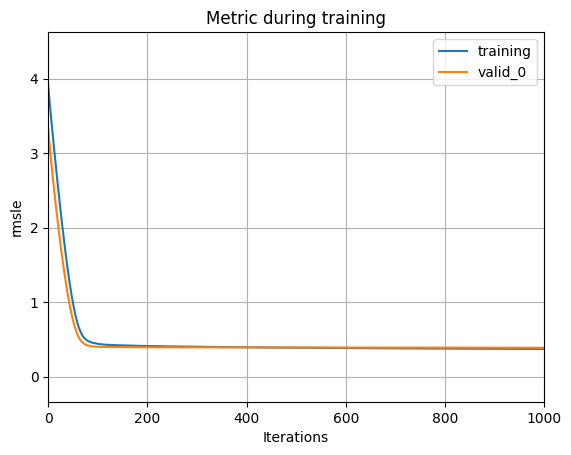

In [ ]:
lgbm.plot_metric(model.evals_result_)

##  2 - Set forecast parameters

In [ ]:
# Forecast_start_date = start date of the validation dataset
forecast_start_date = pd.to_datetime("2017-07-17")     #X_val.index.get_level_values(1)[0]

# Forecast_horizon = 30 days
time_steps = 30
forecast_horizon = pd.date_range(start=forecast_start_date,
                                 periods=time_steps,
                                 freq="D")

# Forecast_end_date = 2017-08-15, end date of the validation dataset
forecast_end_date = forecast_horizon[-1]


# Look_back_window_size = 55 days before forecast_start_date=2017-07-17 (to specify how much data before forecast_start_date is required for creating lag and window features)
periods = 55
look_back_window_size = np.timedelta64(periods, "D")
look_back_window_range = pd.date_range(start=forecast_start_date - look_back_window_size, periods=periods,freq="D")

# Input_start_date (We need data 55 days before forecast_start_date=2017-08-16)
input_start_date = forecast_start_date - look_back_window_size

print(f"Forecast start date is {forecast_start_date}")
print(f"Forecast end date is {forecast_end_date}\n")
print(f"Forecast horizon is {time_steps} days:\n {forecast_horizon}\n")
print(f"Look-back window size for creating lag and window features is {look_back_window_size}, starting from {forecast_start_date - look_back_window_size}\n {look_back_window_range}\n")
print(f"Input start date is {input_start_date}")

Forecast start date is 2017-07-17 00:00:00
Forecast end date is 2017-08-15 00:00:00

Forecast horizon is 30 days:
 DatetimeIndex(['2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', freq='D')

Look-back window size for creating lag and window features is 55 days, starting from 2017-05-23 00:00:00
 DatetimeIndex(['2017-05-23', '2017-05-24', '2017-05-25', '2017-05-26',
               '2017-05-27', '2017-05-28', '2017-05-29', '2017-05-30',
               '2017-05-31', '2017-06-01', '201

## 3 - Load data for creating features and making the first forecast

In [ ]:
# Use the dataset with encoded features
enc_data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/enc_data")
full_enc_data_dir = enc_data_dir / "full_data.parquet"

# Get the data of one store and within a period from input_start_date to forecast_end_date
df = pd.read_parquet(
    path=full_enc_data_dir,
    engine="pyarrow",
    filters=[("store_nbr", "=", "1"),
             ("date", ">=", input_start_date),
             ("date", "<=", forecast_end_date )
            ]
    )

# Remove unused id categories
df["id"] = df["id"].astype(dtype="category")
df["id"] = df["id"].cat.remove_unused_categories()

# Set id and date as index (needed for some sktime transformers)
df = df.set_index(["id", "date"]).sort_index()

# # Check "transactions" and "sales" columns
# idx = pd.IndexSlice
# df.loc[idx[:, idx["2017-08-16":]], ["transactions", "sales"]]
# # Reduce size
# df = reduce_memory_usage(df)

# Check df_input
print(f"df is from {df.index.min()[1]} to {df.index.max()[1]} and has a shape of {df.shape}")
df

df is from 2017-05-23 00:00:00 to 2017-08-15 00:00:00 and has a shape of (2805, 20)


store_nbr      family  sales  onpromotion  \
id           date                                                   
1_AUTOMOTIVE 2017-05-23         1  AUTOMOTIVE   4.00         0.00   
             2017-05-24         1  AUTOMOTIVE   7.00         0.00   
             2017-05-25         1  AUTOMOTIVE   2.00         0.00   
             2017-05-26         1  AUTOMOTIVE   1.00         0.00   
             2017-05-27         1  AUTOMOTIVE   1.00         0.00   
...                           ...         ...    ...          ...   
1_SEAFOOD    2017-08-11         1     SEAFOOD  19.42         4.00   
             2017-08-12         1     SEAFOOD  20.15         0.00   
             2017-08-13         1     SEAFOOD  11.38         0.00   
             2017-08-14         1     SEAFOOD  14.13         0.00   
             2017-08-15         1     SEAFOOD  22.49         0.00   

                         transactions  oil_price_interpolated  \
id           date                                               
1_AUTOMOTIVE 2017-05-23       1701.00                   51.12   
             2017-05-24       1844.00                   50.99   
             2017-05-25       1663.00                   48.57   
             2017-05-26        580.00                   49.58   
             2017-05-27       1116.00                   49.58   
...                               ...                     ...   
1_SEAFOOD    2017-08-11        570.00                   48.81   
             2017-08-12       1004.00                   48.80   
             2017-08-13        416.00                   48.19   
             2017-08-14       1733.00                   47.59   
             2017-08-15       1693.00                   47.57   

                        is_Local_holiday is_Regional_holiday  \
id           date                                              
1_AUTOMOTIVE 2017-05-23       no_holiday          no_holiday   
             2017-05-24       no_holiday          no_holiday   
             2017-05-25       no_holiday          no_holiday   
             2017-05-26       no_holiday          no_holiday   
             2017-05-27       no_holiday          no_holiday   
...                                  ...                 ...   
1_SEAFOOD    2017-08-11       no_holiday          no_holiday   
             2017-08-12       no_holiday          no_holiday   
             2017-08-13       no_holiday          no_holiday   
             2017-08-14       no_holiday          no_holiday   
             2017-08-15       no_holiday          no_holiday   

                        is_National_holiday wage_day earthquake_day  \
id           date                                                     
1_AUTOMOTIVE 2017-05-23          no_holiday       no             no   
             2017-05-24          no_holiday       no             no   
             2017-05-25          no_holiday       no             no   
             2017-05-26            National       no             no   
             2017-05-27          no_holiday       no             no   
...                                     ...      ...            ...   
1_SEAFOOD    2017-08-11            National       no             no   
             2017-08-12          no_holiday       no             no   
             2017-08-13          no_holiday       no             no   
             2017-08-14          no_holiday       no             no   
             2017-08-15          no_holiday      yes             no   

                        earthquake_impact  sales_ewma7_mean  sales_ewma7_std  \
id           date                                                              
1_AUTOMOTIVE 2017-05-23                no              2.94             1.92   
             2017-05-24                no              3.21             1.74   
             2017-05-25                no              4.15             2.33   
             2017-05-26                no              3.62             2.25   
             2017-05-27                no  

## 4 - Create a predict df for recursive forecasting (`df_predict`)

In [ ]:
# Create the "date" index for df_predict
date_index = pd.date_range(
    start=input_start_date,
    end=forecast_end_date,
    freq="D",
)

# Create the "id" index for df_predict
# (i.e. "id" index from df_input)
id_index = df.index.levels[0]

# Create multi-index ("id" & "date") for df_predict
multi_index = pd.MultiIndex.from_product(
    iterables=[id_index, date_index],
    names=df.index.names)

# Create the dataframe for recursive prediction
df_predict = pd.DataFrame(
    data=df,
    index=multi_index)


# Check df_predict
print(f"df is from {df.index.min()[1]} to {df.index.max()[1]} and has a shape of {df.shape} \n")
print(f"df_predict is from {df_predict.index.min()[1]} to {df_predict.index.max()[1]} and has a shape of {df_predict.shape}")

df is from 2017-05-23 00:00:00 to 2017-08-15 00:00:00 and has a shape of (2805, 20) 

df_predict is from 2017-05-23 00:00:00 to 2017-08-15 00:00:00 and has a shape of (2805, 20)


## 5 - Recusive forecasting loop

Up to this point, we have:
1. `model`: A trained one-step ahead forecasting model
2. `pipeline`: The feature engineering pipeline to recursively create neccessary features
3. `df_predict`: the predict dataset that (1) contains the past values needed for making one-step ahead forecast and (2) will store each forecasted value of "sales" after each iteration/forecast date from 2017-08-16 to 2017-08-31

We will use them in our recusive forecasting loop

In [ ]:
print(f"Look back window size is {look_back_window_size}, backward from and excluding {forecast_start_date}. Therefore, we have:")
print(f"The first date of df_predict is {df_predict.index.levels[1].min()}\nThe last date of df_predict is {df_predict.index.levels[1].max()}\n")
print(f"The forecast horizon is:\n {forecast_horizon}")

Look back window size is 55 days, backward from and excluding 2017-07-17 00:00:00. Therefore, we have:
The first date of df_predict is 2017-05-23 00:00:00
The last date of df_predict is 2017-08-15 00:00:00

The forecast horizon is:
 DatetimeIndex(['2017-07-17', '2017-07-18', '2017-07-19', '2017-07-20',
               '2017-07-21', '2017-07-22', '2017-07-23', '2017-07-24',
               '2017-07-25', '2017-07-26', '2017-07-27', '2017-07-28',
               '2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', freq='D')


In [ ]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_date in forecast_horizon:
    # At each iteration, we will:
    # 1-Create the features, using the feature engineering pipeline
    proc_features = pipeline.transform(df_predict)
    proc_features = proc_features.drop(columns=["store_nbr", "family", "sales", "transactions"])


    # 2-Access the features that we have on each specific forecast date (e.g. available features on 2017-08-16) --> Use them to forecast "sales" (e.g. on 2017-08-16)
    date_mask = (proc_features.index.get_level_values(-1) == forecast_date)
    input_features = proc_features.loc[date_mask]

    # 3-Forecast "sales" (e.g. on 2017-08-16)
    y_pred = model.predict(input_features)

    # 4-Append/save each forecasted values of "sales" to the "sales" column in df_predict.
    # (After this, df_predict will be used for the next iteration of re-creating the lag and window features and making forecast (e.g. for 2017-08-17))
    df_predict.loc[date_mask, ["sales"]] = y_pred

    print(f"Sales on {forecast_date} has been forecasted")

Sales on 2017-07-17 00:00:00 has been forecasted
Sales on 2017-07-18 00:00:00 has been forecasted
Sales on 2017-07-19 00:00:00 has been forecasted
Sales on 2017-07-20 00:00:00 has been forecasted
Sales on 2017-07-21 00:00:00 has been forecasted
Sales on 2017-07-22 00:00:00 has been forecasted
Sales on 2017-07-23 00:00:00 has been forecasted
Sales on 2017-07-24 00:00:00 has been forecasted
Sales on 2017-07-25 00:00:00 has been forecasted
Sales on 2017-07-26 00:00:00 has been forecasted
Sales on 2017-07-27 00:00:00 has been forecasted
Sales on 2017-07-28 00:00:00 has been forecasted
Sales on 2017-07-29 00:00:00 has been forecasted
Sales on 2017-07-30 00:00:00 has been forecasted
Sales on 2017-07-31 00:00:00 has been forecasted
Sales on 2017-08-01 00:00:00 has been forecasted
Sales on 2017-08-02 00:00:00 has been forecasted
Sales on 2017-08-03 00:00:00 has been forecasted
Sales on 2017-08-04 00:00:00 has been forecasted
Sales on 2017-08-05 00:00:00 has been forecasted
Sales on 2017-08-06 

In [ ]:
# --- GET FORECAST FROM PREDICT DATAFRAME--- #
date_index = df_predict.index.get_level_values(-1)
date_mask = (date_index >= forecast_horizon[0]) & (date_index <= forecast_horizon[-1])

# Mark the forecast in df_predict
df_predict["is_forecast"] = date_mask

# Create a separate dataframe for our forecast
y_pred = df_predict.loc[date_mask, ["sales"]]
y_pred

sales
id           date             
1_AUTOMOTIVE 2017-07-17   4.35
             2017-07-18   4.36
             2017-07-19   4.25
             2017-07-20   4.24
             2017-07-21   4.52
...                        ...
1_SEAFOOD    2017-08-11  28.16
             2017-08-12  20.86
             2017-08-13  11.62
             2017-08-14  21.10
             2017-08-15  23.39

[990 rows x 1 columns]

In [ ]:
y_true_onestore = y_val.reset_index()[y_val.reset_index()['id'].str.startswith("1_")]["sales"].values
X_val_onestore = X_val[X_val.index.get_level_values(0).str.startswith("1_")]

recursive_result_df = pd.DataFrame(
    data={"y_pred": y_pred["sales"].values, "y_true": y_true_onestore},
    index=X_val_onestore.index)

recursive_result_df

y_pred  y_true
id           date                      
1_AUTOMOTIVE 2017-07-17    4.35    2.00
             2017-07-18    4.36    3.00
             2017-07-19    4.25    7.00
             2017-07-20    4.24    4.00
             2017-07-21    4.52   10.00
...                         ...     ...
1_SEAFOOD    2017-08-11   28.16   19.42
             2017-08-12   20.86   20.15
             2017-08-13   11.62   11.38
             2017-08-14   21.10   14.13
             2017-08-15   23.39   22.49

[990 rows x 2 columns]

In [ ]:
# Save the result

trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
result_dir = lgbm_dir/ "OneStore_recursive_results"
result_dir.mkdir(exist_ok=True)

out_dir = result_dir / "RecursiveResult_ypred_valsplit.parquet"
y_pred.to_parquet(out_dir)

out_dir = result_dir / "RecursiveResult_dfpredict_valsplit.parquet"
df_predict.to_parquet(out_dir)

out_dir = result_dir / "RecursiveResult_procfeatures_valsplit.parquet"
proc_features.to_parquet(out_dir)

out_dir = result_dir / "RecursiveResult_resultdf_valsplit.parquet"
recursive_result_df.to_parquet(out_dir)

# EVALUATE ONE STORE RESULT

## Load the saved results

In [ ]:
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
result_dir = lgbm_dir/ "OneStore_recursive_results"

in_dir = result_dir / "RecursiveResult_ypred_valsplit.parquet"
y_pred = pd.read_parquet(path=in_dir)

in_dir = result_dir / "RecursiveResult_dfpredict_valsplit.parquet"
df_predict = pd.read_parquet(path=in_dir)

in_dir = result_dir / "RecursiveResult_procfeatures_valsplit.parquet"
proc_features = pd.read_parquet(path=in_dir)

in_dir = result_dir / "RecursiveResult_resultdf_valsplit.parquet"
recursive_result_df = pd.read_parquet(path=in_dir)

result_dir = lgbm_dir/ "InSample_results"
in_dir = result_dir / "InsampleForecast_scaled_387_valsplit.parquet"
insample_result_df = pd.read_parquet(path=in_dir)

## rmsle

In [ ]:
rmsle(recursive_result_df["y_true"].values, recursive_result_df["y_pred"].values)

('rmsle', 0.4023860506467558, False)

## Plot

['1_HARDWARE' '1_PREPARED FOODS' '1_SEAFOOD' '1_GROCERY I' '1_HOME CARE'
 '1_SCHOOL AND OFFICE SUPPLIES' '1_POULTRY' '1_DELI' '1_BREAD BAKERY'
 '1_CLEANING' '1_AUTOMOTIVE' '1_LIQUOR,WINE,BEER']


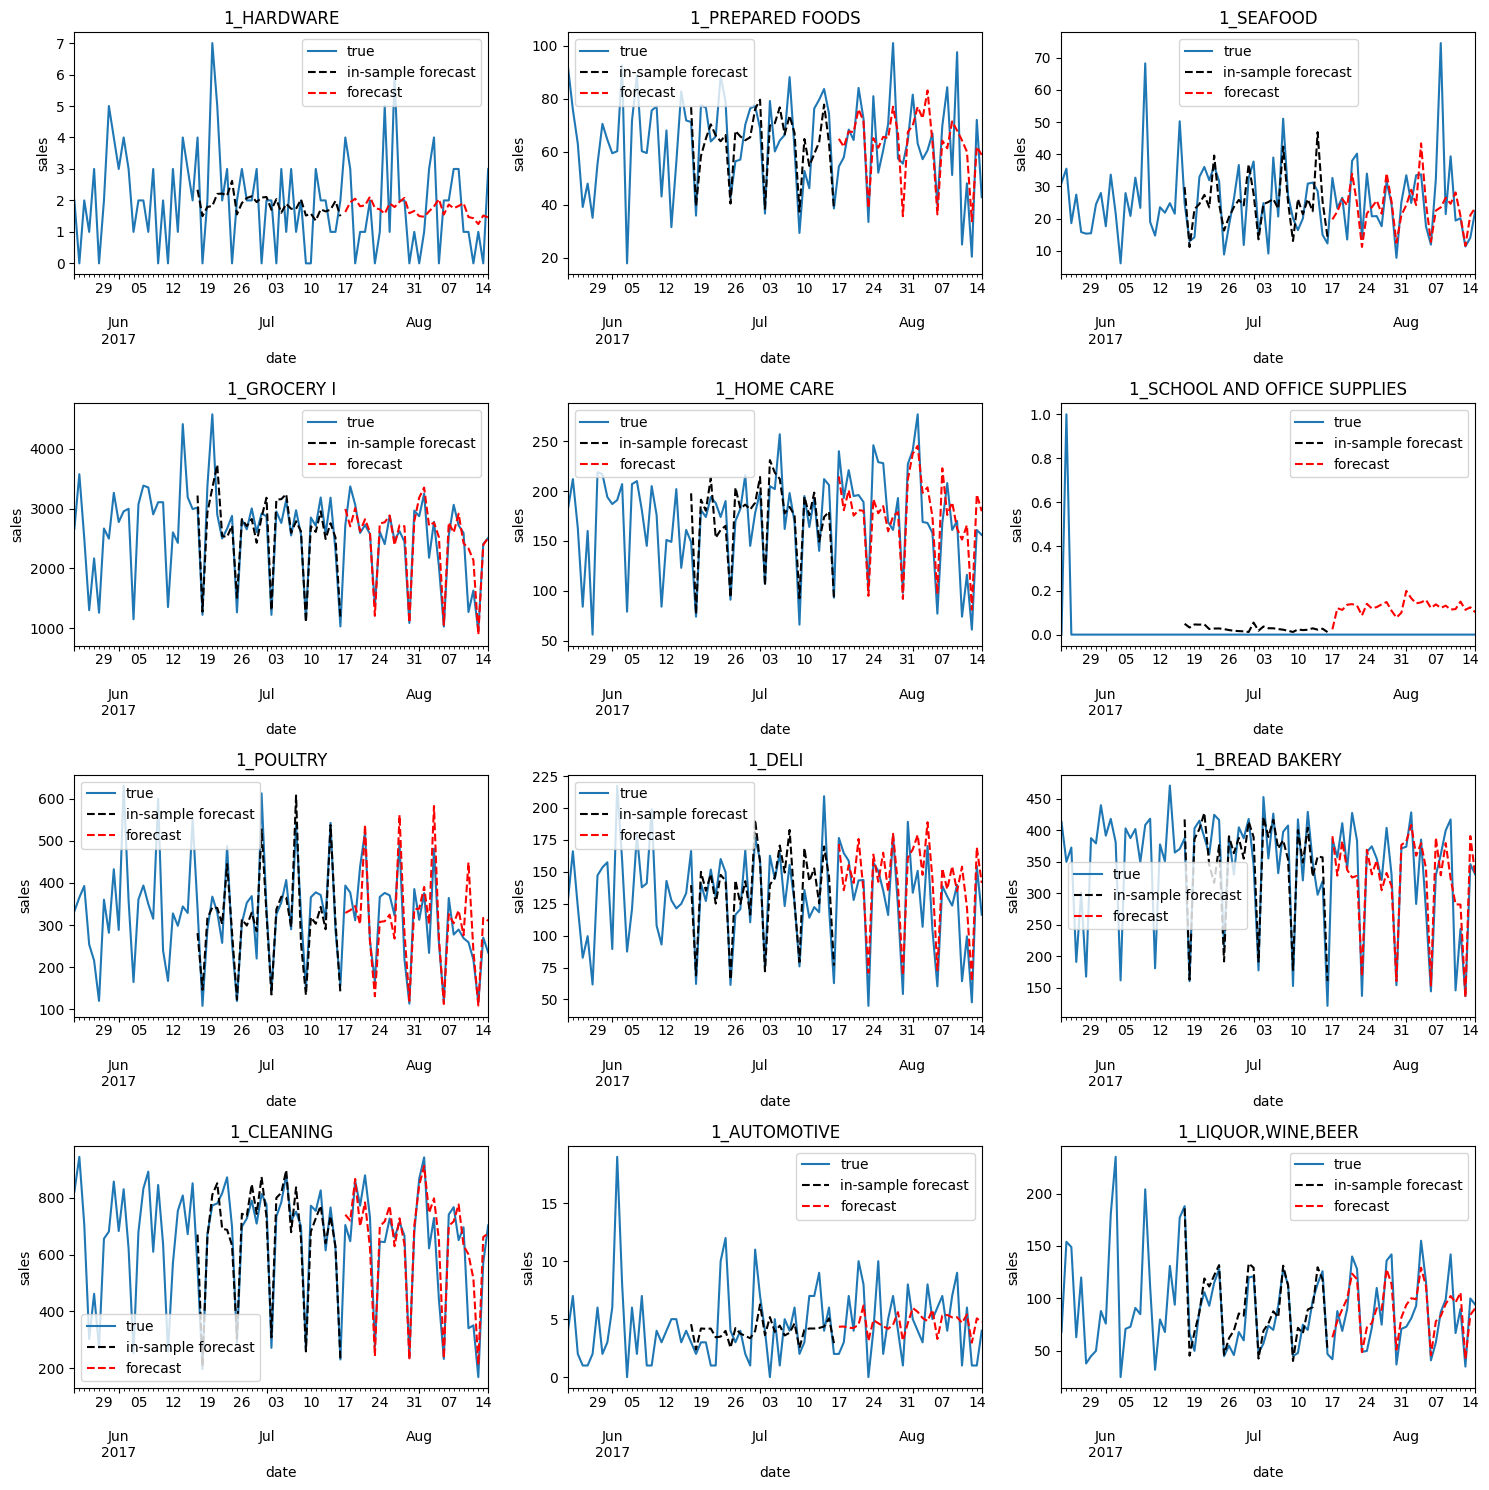

In [ ]:
# Get 12 random ids
n_series = 12

# np.random.seed(0)
random_ids = np.random.choice(
    df_predict.index.levels[0].values,
    size=n_series,
    replace=False)

print(random_ids)

# Plot subset of forecasts
n_series = 12
fig, ax = plt.subplots(nrows=n_series // 3, ncols=3, figsize=[15, 15])

for index, ax in enumerate(ax.flatten()):
    random_id = random_ids[index]

    # Plot true values
    df.loc[random_id, "sales"].plot(ax=ax)

    # Plot in-sample forecasts
    insample_result_df.loc[random_id,"y_pred"].plot(ax=ax, linestyle="--", color="k")

    # Plot recursive forecasts
    recursive_result_df.loc[random_id, "y_pred"].plot(ax=ax, linestyle="--", color="r")

    ax.set_ylabel("sales")
    ax.set_title(random_id)
    ax.legend(["true", "in-sample forecast", "forecast"])

plt.tight_layout()
plt.show()


### LightGBM feature importance

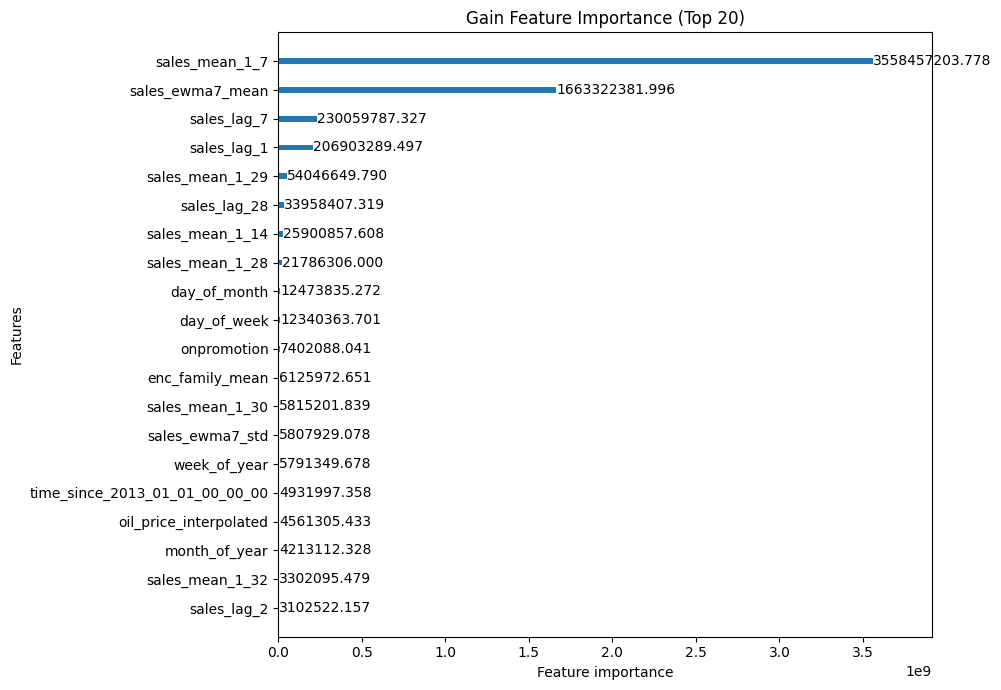

In [ ]:
from lightgbm import plot_importance

# Plot gain feature importance
fig, ax = plt.subplots(figsize=(10, 7))
ax = plot_importance(
    model,
    importance_type="gain",     #If “gain”, result contains total gains of splits which use the feature.
    max_num_features=20,
    grid=False,
    ax=ax
)
plt.title('Gain Feature Importance (Top 20)')
plt.tight_layout()

# f_out = plots_dir / "feat_importance_gain.png"
# fig.savefig(f_out)

### SHAP

In [ ]:
!pip install shap --quiet
import shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 42.7 MB/s eta 0:00:00


In [ ]:
#Let's randomly sample a % of datapoints from each time series to use with SHAP.
X_shap = X_train.groupby(level=0).apply(lambda x: x.sample(frac=0.05)).droplevel(0)
X_shap

sales_lag_1  sales_lag_31  sales_lag_30  \
id            date                                                  
10_AUTOMOTIVE 2013-06-27         0.00          0.00          0.00   
              2014-04-09         0.00          0.00          0.00   
              2015-01-28         0.00          0.00          0.00   
              2014-12-26         0.00          0.00          0.00   
              2016-05-10         0.00          0.00          0.00   
...                               ...           ...           ...   
9_SEAFOOD     2016-01-08         0.00          0.00          0.00   
              2017-01-31         0.00          0.00          0.00   
              2016-05-07         0.00          0.00          0.00   
              2014-12-01         0.00          0.00          0.00   
              2013-08-02         0.00          0.00          0.00   

                          sales_lag_28  sales_lag_29  sales_lag_7  \
id            date                                                  
10_AUTOMOTIVE 2013-06-27          0.00          0.00         0.00   
              2014-04-09          0.00          0.00         0.00   
              2015-01-28          0.00          0.00         0.00   
              2014-12-26          0.00          0.00         0.00   
              2016-05-10          0.00          0.00         0.00   
...                                ...           ...          ...   
9_SEAFOOD     2016-01-08          0.00          0.00         0.00   
              2017-01-31          0.00          0.00         0.00   
              2016-05-07          0.00          0.00         0.00   
              2014-12-01          0.00          0.00         0.00   
              2013-08-02          0.00          0.00         0.00   

                          sales_lag_2  sales_mean_1_28  sales_mean_1_7  \
id            date                                                       
10_AUTOMOTIVE 2013-06-27         0.00             0.00            0.00   
              2014-04-09         0.00             0.00            0.00   
              2015-01-28         0.00             0.00            0.00   
              2014-12-26         0.00             0.00            0.00   
              2016-05-10         0.00             0.00            0.00   
...                               ...              ...             ...   
9_SEAFOOD     2016-01-08         0.00             0.00            0.00   
              2017-01-31         0.00             0.00            0.00   
              2016-05-07         0.00             0.00            0.00   
              2014-12-01         0.00             0.00            0.00   
              2013-08-02         0.00             0.00            0.00   

                          sales_mean_7_7  sales_mean_7_28  sales_mean_1_32  \
id            date                                                           
10_AUTOMOTIVE 2013-06-27            0.00             0.00             0.00   
              2014-04-09            0.00             0.00             0.00   
              2015-01-28            0.00             0.00             0.00   
              2014-12-26            0.00             0.00             0.00   
              2016-05-10            0.00             0.00             0.00   
...                                  ...              ...              ...   
9_SEAFOOD     2016-01-08            0.00             0.00             0.00   
              2017-01-31            0.00             0.00             0.00   
              2016-05-07            0.00             0.00             0.00   
              2014-12-01            0.00             0.00             0.00   
              2013-08-02            0.00             0.00             0.00   

                          sales_mean_28_28  sales_mean_1_31  sales_mean_1_14  \
id            date                                                             
10_AUTOMOTIVE 2013-06-27              0.00             0.00             0.00   
            

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)

In [ ]:
# Save the X_shap dataframe and calculated shap values.
out_dir = plots_dir / "X_shap_valsplit.parquet"
X_shap.to_parquet(out_dir)

out_dir = plots_dir / "shap_values_valsplit.parquet"
pd.DataFrame(shap_values, columns=X_shap.columns).to_parquet(out_dir)

In [ ]:
# Note: LightGBM can natively produce shap values using pred_contrib=True.
# So we could also have done the following to obtain the shap values: shap_values = model.predict(X_shap, pred_contrib=True)

In [ ]:
# Plot the feature importances
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X_train.columns,
    plot_type="bar",
    max_display=20,
    plot_size=(10, 7),
    show=False
)

fig = plt.gcf()
plt.tight_layout()
f_out = plots_dir / "feat_importance_shap.png"
fig.savefig(f_out)

# ALL STORES - Multi-step forecasting using recursive approach

In [4]:
#--- Load the trained model ---#
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
model = joblib.load(lgbm_dir / "TrainedModel_scaled_387.joblib")

#--- Load the feature engineering pipeline ---#
pipeline_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/pipelines")
pipeline = joblib.load(pipeline_dir/"pipeline_lgbm_scaled.joblib")

#--- Display the model and pipeline ---#
display(model, pipeline)

LGBMRegressor(bagging_freq=1, early_stopping_round=100,
              feature_fraction=0.6000000000000001,
              learning_rate=0.07428931643416213, max_bin=132, max_depth=11,
              min_data_in_leaf=200, min_data_per_groups=100, n_estimators=1000,
              num_leaves=450, objective='tweedie', seed=42, subsample=0.8,
              tweedie_variance_power=1.2, verbose=-1)

FeatureUnion(transformer_list=[('pipeline-1',
                                Pipeline(steps=[('featureunion',
                                                 FeatureUnion(transformer_list=[('windowsummarizer-1',
                                                                                 WindowSummarizer(lag_feature={'lag': [1, 2, 7, 28, 29, 30, 31],
                              'mean': [[1, 7], [1, 14], [1, 28], [1, 29],
                                       [1, 30], [1, 31], [1, 32], [7, 7],
                                       [7, 14], [7, 28], [28, 7], [28, 28]],
                              'std': [[1, 7], [1, 14], [1, 28], [1, 29],
                                      [1, 30], [1, 31], [1, 32], [7, 7],
                                      [7, 14], [7, 2...
                               ('pipeline-2',
                                Pipeline(steps=[('columntransformer',
                                                 ColumnTransformer(remainder='passthrough',
                                                                   transformers=[('minmaxscaler',
                                                                                  MinMaxScaler(),
                                                                                  ['onpromotion',
                                                                                   'oil_price_interpolated',
                                                                                   'enc_family_mean',
                                                                                   'enc_store_nbr_mean',
                                                                                   'enc_city_mean',
                                                                                   'enc_state_mean',
                                                                                   'enc_type_mean',
                                                                                   'enc_cluster_mean',
                                                                                   'sales_ewma7_mean',
                                                                                   'sales_ewma7_std'])],
                                                                   verbose_feature_names_out=False))]))])

In [5]:
# Forecast_start_date = 2017-08-16, start date of the test dataset
forecast_start_date = pd.to_datetime("2017-08-16")

# Forecast_horizon = 16 days, from 2017-08-16 to 2017-08-31
time_steps = 16
forecast_horizon = pd.date_range(start=forecast_start_date,
                                 periods=time_steps,
                                 freq="D")

# Forecast_end_date = 2017-08-31, end date of the test dataset
forecast_end_date = forecast_horizon[-1]


# Look_back_window_size = 55 days before forecast_start_date (to specify how much data before forecast_start_date=2017-08-16  is required for creating lag and window features)
periods = 55
look_back_window_size = np.timedelta64(periods, "D")
look_back_window_range = pd.date_range(start=forecast_start_date - look_back_window_size, periods=periods,freq="D")

# Input_start_date (We need data 55 days before forecast_start_date=2017-08-16)
input_start_date = forecast_start_date - look_back_window_size

print(f"Forecast start date is {forecast_start_date}")
print(f"Forecast end date is {forecast_end_date}\n")
print(f"Forecast horizon is {time_steps} days:\n {forecast_horizon}\n")
print(f"Look-back window size for creating lag and window features is {look_back_window_size}, starting from {forecast_start_date - look_back_window_size}\n {look_back_window_range}\n")
print(f"Input start date is {input_start_date}")

Forecast start date is 2017-08-16 00:00:00
Forecast end date is 2017-08-31 00:00:00

Forecast horizon is 16 days:
 DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', freq='D')

Look-back window size for creating lag and window features is 55 days, starting from 2017-06-22 00:00:00
 DatetimeIndex(['2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
               '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29',
               '2017-06-30', '2017-07-01', '2017-07-02', '2017-07-03',
               '2017-07-04', '2017-07-05', '2017-07-06', '2017-07-07',
               '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11',
               '2017-07-12', '2017-07-13', '2017-07-14', '2017-07-15',
               '201

In [6]:
# Set directories
# Use the dataset with encoded features
enc_data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/enc_data")
full_enc_data_dir = enc_data_dir / "full_data.parquet"

trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
result_dir = lgbm_dir/ "AllStore_recursive_results"
result_dir.mkdir(exist_ok=True)

In [8]:
stores = np.arange(1, 5, 1).astype("str")


for store in stores:


  #---LOAD DATA---#
  # Get the data of one store and within a period from input_start_date to forecast_end_date
  df = pd.read_parquet(
      path=full_enc_data_dir,
      engine="pyarrow",
      filters=[("store_nbr", "=", store),
               ("date", ">=", input_start_date),
               ("date", "<=", forecast_end_date )
              ]
      )
  # Remove unused id categories
  df["id"] = df["id"].astype(dtype="category")
  df["id"] = df["id"].cat.remove_unused_categories()
  # Set id and date as index (needed for some sktime transformers)
  df = df.set_index(["id", "date"]).sort_index()


  #--- CREATE df_predict ---#
  # Create the "date" index for df_predict
  date_index = pd.date_range(
      start=input_start_date,
      end=forecast_end_date,
      freq="D",
  )
  # Create the "id" index for df_predict (i.e. "id" index from df_input)
  id_index = df.index.levels[0]
  # Create multi-index ("id" & "date") for df_predict
  multi_index = pd.MultiIndex.from_product(
      iterables=[id_index, date_index],
      names=df.index.names)
  # Create the dataframe for recursive prediction
  df_predict = pd.DataFrame(
      data=df,
      index=multi_index)


  # --- RECURSIVE FORECASTING LOOP --- #
  for forecast_date in forecast_horizon:
      # At each iteration, we will:
      # 1-Create the features, using the feature engineering pipeline
      proc_features = pipeline.transform(df_predict)
      proc_features = proc_features.drop(columns=["store_nbr", "family", "sales", "transactions"])
      # 2-Access the features that we have on each specific forecast date (e.g. available features on 2017-08-16) --> Use them to forecast "sales" (e.g. on 2017-08-16)
      date_mask = (proc_features.index.get_level_values(-1) == forecast_date)
      input_features = proc_features.loc[date_mask]
      # 3-Forecast "sales" (e.g. on 2017-08-16)
      y_pred = model.predict(input_features)
      # 4-Append/save each forecasted values of "sales" to the "sales" column in df_predict.
      # (After this, df_predict will be used for the next iteration of re-creating the lag and window features and making forecast (e.g. for 2017-08-17))
      df_predict.loc[date_mask, ["sales"]] = y_pred


  # --- GET FORECAST FROM PREDICT DATAFRAME--- #
  date_mask = (df_predict.index.get_level_values(-1) >= forecast_horizon[0]) & (df_predict.index.get_level_values(-1) <= forecast_horizon[-1])
  # Mark the forecast in df_predict
  df_predict["is_forecast"] = date_mask
  # Create a separate dataframe for the forecasted sales
  y_pred = df_predict.loc[date_mask, ["sales"]]


  #--- SAVE THE RESULT ---#
  out_dir = result_dir / f"RecursiveResult_y_pred_{store}.parquet"
  y_pred.to_parquet(out_dir)

  out_dir = result_dir / f"RecursiveResult_df_predict_{store}.parquet"
  df_predict.to_parquet(out_dir)

  out_dir = result_dir / f"RecursiveResult_proc_features_{store}.parquet"
  proc_features.to_parquet(out_dir)

  print(f"forecast for store {store} is done")

  #--- DELETE dfs TO SAVE MEMORY ---#
  del df_predict, proc_features, y_pred, df


forecast for store 1 is done
forecast for store 2 is done
forecast for store 3 is done
forecast for store 4 is done


In [ ]:
trained_models_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/for_models/trained_models")
lgbm_dir = trained_models_dir/ "lgbm_scaled_387"
result_dir = lgbm_dir/ "AllStore_recursive_results"
in_dir = result_dir / f"RecursiveResult_y_pred_5.parquet"

check = pd.read_parquet(path=in_dir)


# Sample Submission
raw_data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Store-Sales/raw_data")
sample_submission_df = pd.read_csv(raw_data_dir / "sample_submission.csv")
test_df = pd.read_csv(raw_data_dir / "test.csv", parse_dates=["date"])

In [ ]:
check = check.reset_index()
check["store_nbr"] = check["id"].str[:1]
check["family"] = check["id"].str[2:]
check.sort_values(by=["date", "store_nbr"])
# How to get back store_nbr and family

,id,date,sales,store_nbr,family
0,5_AUTOMOTIVE,2017-08-16,6.06,5,AUTOMOTIVE
16,5_BABY CARE,2017-08-16,0.26,5,BABY CARE
32,5_BEAUTY,2017-08-16,7.15,5,BEAUTY
48,5_BEVERAGES,2017-08-16,1839.64,5,BEVERAGES
64,5_BOOKS,2017-08-16,0.01,5,BOOKS
...,...,...,...,...,...
463,5_POULTRY,2017-08-31,198.01,5,POULTRY
479,5_PREPARED FOODS,2017-08-31,50.02,5,PREPARED FOODS
495,5_PRODUCE,2017-08-31,1302.01,5,PRODUCE
511,5_SCHOOL AND OFFICE SUPPLIES,2017-08-31,1.32,5,SCHOOL AND OFFICE SUPPLIES


In [ ]:
test_df.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [ ]:
sample_submission_df

,id,sales
0,3000888,0.00
1,3000889,0.00
2,3000890,0.00
3,3000891,0.00
4,3000892,0.00
...,...,...
28507,3029395,0.00
28508,3029396,0.00
28509,3029397,0.00
28510,3029398,0.00
